In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt


from torch.distributions.multivariate_normal import MultivariateNormal



import numpy as np



from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

In [61]:

batch_size = 100
take_latent_max =10
num_epoch = 10
input_dim=28*28
output_dim=input_dim
en_hidden1_dim = 500
en_hidden2_dim = 500
en_hidden3_dim = 2000
latent_dim= 10
de_hidden1_dim = 2000
de_hidden2_dim = 500
de_hidden3_dim = 500

mi_hidden1_dim = 1000
mi_hidden2_dim = 1000


log_interval = 600

K_model_cluster = 10
K_real_cluster = 10

beta= 1.
beta_start = beta
beta_end = 1.
total_step = 500
beta_delta = (beta_end-beta_start)/total_step


save_folder = 'SGD-factorvae'

KMeans_random_state = 1 #(random seed)
Gaussian_random_state = 1  #(random seed)

eps_N_c = 0
iter_adiabatic =1

qn_value =0

TC_gamma = 10.

stabilizer_eps = 0

In [3]:
device = 'cuda'
kwargs = {'num_workers':1, 'pin_memory':True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=True,download=True,
                   transform=transforms.ToTensor()),
    batch_size=2*batch_size,shuffle=True,**kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data',train=False,transform=transforms.ToTensor()),
    batch_size=batch_size,shuffle=True,**kwargs)


In [4]:
def initialize_centers():

    mu_c = torch.randn(1,latent_dim,K_model_cluster,device=device)
    logvar_c = torch.zeros(1,latent_dim,K_model_cluster).to(device)
    inv_sm_pi_c = torch.zeros(1,1,K_model_cluster).to(device)

    return mu_c,logvar_c,inv_sm_pi_c

In [5]:


#zs_g,ts_g,mus_g,logvars_g = take_latents()
mu_c_g,logvar_c_g,inv_sm_pi_c_g = initialize_centers()
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)
mu_c_g.shape,logvar_c_g.shape,inv_sm_pi_c_g.shape
#mu_c_g,logvar_c_g,pi_c_g,Q_c_g,gamma_c_g,log_P_g = gauss(mus_g,logvars_g,mu_c_g,logvar_c_g,pi_c_g,50)

(torch.Size([1, 10, 10]), torch.Size([1, 10, 10]), torch.Size([1, 1, 10]))

In [6]:
mu_c_g.requires_grad_(True)
logvar_c_g.requires_grad_(True)
inv_sm_pi_c_g.requires_grad_(True)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], device='cuda:0',
       requires_grad=True)

In [7]:
mu_c_g.requires_grad,logvar_c_g.requires_grad,inv_sm_pi_c_g.requires_grad
#F.softmax(inv_sm_pi_c_g,dim=0)

(True, True, True)

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.input_layer = nn.Linear(input_dim,en_hidden1_dim)##728 => 500 for MNIST
        self.encode1_layer = nn.Linear(en_hidden1_dim,en_hidden2_dim)##500 => 500 for MNIST
        self.encode2_layer = nn.Linear(en_hidden2_dim,en_hidden3_dim)##500 => 2000 for MNIST
        self.mu_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.std_layer = nn.Linear(en_hidden3_dim,latent_dim)##2000 => 10 for MNIST
        self.decode1_layer = nn.Linear(latent_dim,de_hidden1_dim)##10 => 2000 for MNIST
        self.decode2_layer = nn.Linear(de_hidden1_dim,de_hidden2_dim)##2000 => 500 for MNIST
        self.decode3_layer = nn.Linear(de_hidden2_dim,de_hidden3_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(de_hidden3_dim,output_dim)##500 => 728 for MN#%%IST

    def encode(self, x):
        en_h1 = F.relu(self.input_layer(x))
        en_h2 = F.relu(self.encode1_layer(en_h1))
        en_h3 = F.relu(self.encode2_layer(en_h2))
        return self.mu_layer(en_h3), self.std_layer(en_h3)
    #入力から中心と分散の対数を作っている


    def reparameterize(self,mu,logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        #torch.randn_like(std)はstdと同じ次元の正規乱数を与えている。N(0,1)**size(std).ただし、標準偏差は対角的。
        return mu + eps*std
    #zの値を確率的に作っている。

    def decode(self,z):
        de_h1 = F.relu(self.decode1_layer(z))
        de_h2 = F.relu(self.decode2_layer(de_h1))
        de_h3 = F.relu(self.decode3_layer(de_h2))
        return torch.sigmoid(self.output_layer(de_h3))
    #zからNNを通したあとに、sigmoidで押し込んでxの値を作っている


    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z),mu,logvar,z
    #出力はxの予測値とzを算出するときの中心と分散になっている


model = VAE().to(device)

optimizer = optim.Adam(model.parameters(),lr=0.002)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


#optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g,inv_sm_pi_c_g],lr=0.002)
optimizer_clustering = optim.Adam([mu_c_g,logvar_c_g],lr=0.002)
scheduler_clustering = torch.optim.lr_scheduler.MultiStepLR(optimizer_clustering,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


In [9]:

class TC_MLP(nn.Module):
    def __init__(self):
        super(TC_MLP, self).__init__()

        self.input_layer = nn.Linear(latent_dim,mi_hidden1_dim)##728 => 500 for MNIST
        self.hidden1_layer = nn.Linear(mi_hidden1_dim,mi_hidden2_dim)##500 => 500 for MNIST
        self.output_layer = nn.Linear(mi_hidden2_dim,1)##500 => 2000 for MNIST

    def forward(self, z):
        h1 = F.leaky_relu(self.input_layer(z))
        h2 = F.leaky_relu(self.hidden1_layer(h1))

        return torch.sigmoid(self.output_layer(h2))
    #出力はxの予測値とzを算出するときの中心と分散になっている


TC_model = TC_MLP().to(device)

optimizer_TC = optim.Adam(TC_model.parameters(),lr=0.002)
scheduler_TC = torch.optim.lr_scheduler.MultiStepLR(optimizer_TC,milestones=[20,40,60,80,100,120,140,160,180,200,220,240,260],gamma=0.9)


In [10]:
def take_latents():
    zs = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    ts = torch.empty(0,dtype=torch.long).to(device).requires_grad_(False)
    mus = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
    logvars = torch.empty(0,latent_dim,1).to(device).requires_grad_(False)
#zs = []
#ts = []

#ts.dtype = torch.int

    #for x, t in test_loader:
    for batch_idx, (x,t) in enumerate(test_loader):
    # original。xがデータ、tがラベル。
    #for i, im in enumerate(x.view(-1, 28, 28).detach().numpy()[:10]):
    #  ax = fig.add_subplot(3, 10, i+1, xticks=[], yticks=[])
    #  ax.imshow(im, 'gray')
    #x = x.to(device)
    # generate from x
        if batch_idx < take_latent_max:
            x = x.to(device)
            with torch.no_grad():
                recon_batch,mu,logvar, z = model(x)
            t = t.to(device)
    #zs.append(z)
    #ts.append(t)
            zs = torch.cat((zs,z.view(-1,latent_dim,1)),0)
            ts = torch.cat((ts,t),0)
            mus = torch.cat((mus,mu.view(-1,latent_dim,1)),0)
            logvars = torch.cat((logvars,logvar.view(-1,latent_dim,1)),0)
    #y = y.view(-1, 28, 28)
    #for i, im in enumerate(y.cpu().detach().numpy()[:10]):
     # ax = fig.add_subplot(3, 10, i+11, xticks=[], yticks=[])
     # ax.imshow(im, 'gray')
    mus = torch.cat((mus,mu_c_g.permute(2,1,0)),0)
    ts = torch.cat((ts,torch.arange(-1,-K_model_cluster-1,-1).to(device)),0)
    return zs,ts,mus,logvars


In [11]:
def gauss(mus,logvars,mu_c,logvar_c,inv_sm_pi_c,iter):

    for i in range(iter):
        with torch.no_grad():
            Q_c = logvar_c+(logvars.exp()+(mus-mu_c).pow(2))/(logvar_c.exp())

            gamma_c = (F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp()))/((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2,keepdim=True))

            N_c = gamma_c.sum(0,keepdim=True)
            log_P = (((F.softmax(inv_sm_pi_c,dim=2)*((-0.5*Q_c.sum(1,keepdim=True)).exp())).sum(2).squeeze()).log()).sum()/((Q_c.shape)[0])
            pi_c= N_c/(N_c.sum())
            mu_c=(gamma_c*mus).sum(0,keepdim=True)/N_c
            logvar_c=((gamma_c*((mus-mu_c).pow(2)+logvars.exp())).sum(0,keepdim=True)/N_c).log()


    return mu_c,logvar_c,pi_c,Q_c,gamma_c,log_P


In [12]:
def drawpoints(mus_numpy,ts_numpy):
    colors = ["red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue","red", "green", "blue", "orange", "purple", "brown", "fuchsia", "grey", "olive", "lightblue"]
    for p,l in zip(points,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),c=colors[l])

cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,center_numpy,center_t_numpy):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for p,l in zip(center_numpy,center_t_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color='black',s=50)

#    plt.xlim(-4,4)
#    plt.ylim(-4,4)
    plt.show()

In [13]:
N_wide = 10
N_sigma =7
def show_generated_samples_c(mu_c,logvar_c):

    for i in range(K_model_cluster):
        sample = torch.empty(latent_dim*(N_wide+1),latent_dim).to(device)
        with torch.no_grad():
            for j in range(latent_dim):
                for k in range(N_wide+1):
                    std_c =torch.zeros(latent_dim).to(device)
                    std_c[j] = (logvar_c_g[0,j,i].exp()).sqrt()
                    sample[j*(N_wide+1)+k,:] = mu_c[0,:,i]+N_sigma*(k-N_wide/2)*std_c/N_wide
            #sample_dist = MultivariateNormal(loc=mu_c[:,:,i],covariance_matrix=torch.diag(logvar_c[0,:,i].exp()))
    #mu_distribution = MultivariateNormal(loc=mu_center.cpu(),covariance_matrix=cov_mus.cpu())
            #sample = sample_dist.sample([64,])
#    sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(latent_dim*(N_wide+1),1,28,28),save_folder+'/sample_c_' + str(i) + '.png',nrow=N_wide+1)
        #生成した６４個のデータを記録しておく

In [14]:
def q_exponential(x,n):
    if n==0:
        return x.exp()
    else:
        return (1. - x/n).pow(-n)

def q_log(x,n):
    if n==0:
        return x.log()
    else:
        return n*(x.pow(1./n)-1.)

In [15]:
def shuffle_latent(z):
    tz = torch.randperm(batch_size)
    z_temp = torch.empty(batch_size,latent_dim).to(device)
    for i in range(latent_dim):
        z_temp[:,i] = z[tz,i]
    return z_temp

In [16]:
def loss_function_c(recon_x,x,mus_f,logvars_f,mu_c_f,logvar_c_f,inv_sm_pi_c_f,D_z):
    BCE = F.binary_cross_entropy(recon_x,x.view(-1,input_dim),reduction='sum')
    KLD = -(q_log(stabilizer_eps+(F.softmax(inv_sm_pi_c_f,dim=2)*(q_exponential(-0.5*((-1.+logvar_c_f-logvars_f+(logvars_f.exp()+(mus_f-mu_c_f).pow(2))/(logvar_c_f.exp())).sum(1,keepdim=True)),qn_value))).sum(2,keepdim=True),qn_value)).sum()
    TC = ((1.+stabilizer_eps)/(1.-D_z+stabilizer_eps)-1.+stabilizer_eps).log().sum()

    return BCE+beta*KLD+TC_gamma*TC

In [17]:
def loss_function_TC(D_z_data,D_z_shuffle):
    return (-(D_z_data+stabilizer_eps).log()-(1.-D_z_shuffle+stabilizer_eps).log()).sum()

In [18]:
def train_c(epoch,mu_c,logvar_c,inv_sm_pi_c):
    model.train()
    TC_model.train()
    train_loss = 0
    for batch_idx, (data,_) in enumerate(train_loader):
        #ラベルは使わないようだ
        data = data.to(device)
        #データをGPUにおくる
        optimizer.zero_grad()
        optimizer_clustering.zero_grad()

        #傾きの初期化
        recon_batch, mu, logvar,z_data = model(data[0:batch_size,:,:])
        z_data_tensor = z_data.detach()
        D_z_data = TC_model(z_data)
        #VAEからバッヂ分のデータと中心と分散のログを受け取る

        loss = loss_function_c(recon_x=recon_batch,x=data[0:batch_size,:,:],mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,inv_sm_pi_c_f=inv_sm_pi_c,D_z=D_z_data)
        #バッヂ分のロスを計算。バッヂ数で割っていないようだ。書き出しのときにデータ数で割っている。
        loss.backward()
        #傾きを計算
        train_loss+= loss.item()
        optimizer.step()
        #NNパラメータの更新

        optimizer_clustering.step()
        #NNクラスタリングパラメータの更新

        optimizer_TC.zero_grad()
        D_z_data_tensor = TC_model(z_data_tensor)
        _, _, _,z_data_shuffle = model(data[batch_size:2*batch_size,:,:])
        D_z_shuffle = TC_model(shuffle_latent(z_data_shuffle.detach()))
        loss_TC = loss_function_TC(D_z_data=D_z_data_tensor,D_z_shuffle=D_z_shuffle)
        loss_TC.backward()
        optimizer_TC.step()
        #MI_MLPの更新

#        print(mu_c_g)
#        print('var_c='.format(logvar_c_g.exp()))

#        print('mu={}'.format(mu.view(-1,latent_dim,1).squeeze()))
#        print('prec_c={}'.format((1./logvar_c_g.exp()).squeeze()))
#        print('quad={}'.format(((((mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1)).squeeze()))
#        print('quadvar={}'.format((((logvar.view(-1,latent_dim,1).exp())/(logvar_c_g.exp())).sum(1)).squeeze()))
#        print('expDKL={}'.format((-0.5*((logvar_c_g+(logvar.view(-1,latent_dim,1).exp()+(mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1,keepdim=True))).exp().squeeze()))
#        print('logDKL={}'.format((((F.softmax(inv_sm_pi_c_g,dim=2)*((-0.5*((logvar_c_g+(logvar.view(-1,latent_dim,1).exp()+(mu.view(-1,latent_dim,1)-mu_c_g).pow(2))/(logvar_c_g.exp())).sum(1,keepdim=True))).exp())).sum(2,keepdim=True)).log()).squeeze()))

        if batch_idx % log_interval ==0:
            #一定間隔でロスを書き出し。epochはここでしか使っていないようだ。len()は最初の次元の大きさを出すのでバッヂの大きさ。
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch,batch_idx*len(data),len(train_loader.dataset),
                100.*batch_idx/len(train_loader),
                loss.item()/len(data)
            ))

#        if batch_idx == 5:
#            break

In [19]:
def test_c(epoch,mu_c,logvar_c,inv_sm_pi_c):
    model.eval()
    TC_model.eval()
    test_loss = 0
    with torch.no_grad():#バックプロパゲーションを行わないから、微分情報を残さない
        for i, (data, _) in enumerate(test_loader):
            #テストデータを取り出す。ラベルはいらない。
            data =data.to(device)
            #データをGPUに送る
            recon_batch, mu, logvar,z_data = model(data)
            D_z_data = TC_model(z_data)
            #データからバッヂ分の再現画像と中心と分散の対数を出している。
            test_loss += loss_function_c(recon_x=recon_batch,x=data,mus_f=mu.view(-1,latent_dim,1),logvars_f=logvar.view(-1,latent_dim,1),mu_c_f=mu_c,logvar_c_f=logvar_c,inv_sm_pi_c_f=inv_sm_pi_c,D_z=D_z_data).item()
            #テストデータでのロスを出している
            if i == 0:
                #はじめのバッヂについて
                n = min(data.size(0),16)
                #nをバッヂのデータ数か８との小さい方として
                comparizon = torch.cat([data[:n],recon_batch.view(batch_size,1,28,28)[:n]])
                #元データと再現データを並べる
                save_image(comparizon.cpu(),'./'+save_folder+'/reconstruction_c_' + str(epoch) + '.png',nrow=n)

                test_loss /= len(test_loader.dataset)
                print('====> Test set loss: {:.4f}'.format(test_loss))

In [20]:
'''
def train_c_epoch(epochs,mu_c,logvar_c,inv_sm_pi_c):
    for epoch in range(1, epochs +1):
        train_c(epoch,mu_c,logvar_c,inv_sm_pi_c)
        test_c(epoch,mu_c,logvar_c,inv_sm_pi_c)
        with torch.no_grad():
            sample = torch.randn(64,latent_dim).to(device)
        #20次元の潜在空間のデータを64個作成して、GPUに送る
            sample = model.decode(sample).cpu()
        #ランダムな潜在変数から画像を生成する。
            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)
        #生成した６４個のデータを記録しておく

'''

"\ndef train_c_epoch(epochs,mu_c,logvar_c,inv_sm_pi_c):\n    for epoch in range(1, epochs +1):\n        train_c(epoch,mu_c,logvar_c,inv_sm_pi_c)\n        test_c(epoch,mu_c,logvar_c,inv_sm_pi_c)\n        with torch.no_grad():\n            sample = torch.randn(64,latent_dim).to(device)\n        #20次元の潜在空間のデータを64個作成して、GPUに送る\n            sample = model.decode(sample).cpu()\n        #ランダムな潜在変数から画像を生成する。\n            save_image(sample.view(64,1,28,28),save_folder+'/sample_c_epoch_' + str(epoch) + '.png',nrow=8)\n        #生成した６４個のデータを記録しておく\n\n"

In [21]:

mu_c_g,logvar_c_g,F.softmax(inv_sm_pi_c_g,dim=2)

(tensor([[[ 1.2973,  1.4047,  0.0241, -1.7028,  0.8122,  0.0493,  0.2799,
            0.1628,  0.7086,  0.7176],
          [ 2.5325, -0.1315, -0.2272, -1.0619, -1.7115, -2.1439,  0.8208,
            0.6451,  1.2621, -0.3799],
          [-0.5139,  0.4895,  0.1495,  0.3254, -0.2687,  0.6975, -0.2148,
           -0.1993, -0.1752, -0.7022],
          [-0.3406, -1.8429,  1.1654, -0.7467, -0.9089, -1.3466, -1.1933,
           -0.7390, -0.1534, -2.6195],
          [ 0.7842,  0.0471, -1.3570,  0.7200,  0.7101,  1.2160,  0.0213,
            0.6160,  0.2927,  0.1231],
          [ 0.8523, -0.0166,  0.1552, -1.4989,  1.0827,  0.3047,  0.9152,
           -0.4614, -0.6301, -0.4888],
          [-1.0563, -0.1127, -0.4686, -1.2337, -1.2488,  0.1347, -0.0764,
           -1.6486, -0.6963,  0.6423],
          [-0.5857, -0.3983, -0.4457,  1.1289, -0.2113, -0.9810,  0.2848,
           -0.1165,  0.3160,  1.5835],
          [-0.1473, -1.1107,  1.0200, -0.7700, -0.9771, -1.5334, -0.2198,
           -0.7195,  0

In [22]:
#infomax_alpha = 2.
beta_delta = 0.01

In [62]:
for i in range(200):
    #train_c_epoch(epochs=1,mu_c=mu_c_g,logvar_c=logvar_c_g,pi_c=pi_c_g)

    train_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,inv_sm_pi_c=inv_sm_pi_c_g)
    test_c(epoch=i,mu_c=mu_c_g,logvar_c=logvar_c_g,inv_sm_pi_c=inv_sm_pi_c_g)
    scheduler.step()
    scheduler_clustering.step()
    scheduler_TC.step()

    beta += beta_delta


Train Epoch: 0 [0/60000 (0%)]	Loss: 48.159995
====> Test set loss: 1.0382
Train Epoch: 1 [0/60000 (0%)]	Loss: 49.555361
====> Test set loss: 1.0494
Train Epoch: 2 [0/60000 (0%)]	Loss: 48.918149
====> Test set loss: 1.0317
Train Epoch: 3 [0/60000 (0%)]	Loss: 49.305156
====> Test set loss: 1.1216
Train Epoch: 4 [0/60000 (0%)]	Loss: 46.300415
====> Test set loss: 1.0767
Train Epoch: 5 [0/60000 (0%)]	Loss: 46.894312
====> Test set loss: 1.0928
Train Epoch: 6 [0/60000 (0%)]	Loss: 46.995586
====> Test set loss: 1.1011
Train Epoch: 7 [0/60000 (0%)]	Loss: 50.917168
====> Test set loss: 1.0885
Train Epoch: 8 [0/60000 (0%)]	Loss: 50.360986
====> Test set loss: 1.0478
Train Epoch: 9 [0/60000 (0%)]	Loss: 49.183022
====> Test set loss: 1.1325
Train Epoch: 10 [0/60000 (0%)]	Loss: 46.191333
====> Test set loss: 1.0545
Train Epoch: 11 [0/60000 (0%)]	Loss: 46.456685
====> Test set loss: 1.0540
Train Epoch: 12 [0/60000 (0%)]	Loss: 48.680410
====> Test set loss: 1.0882
Train Epoch: 13 [0/60000 (0%)]	Loss

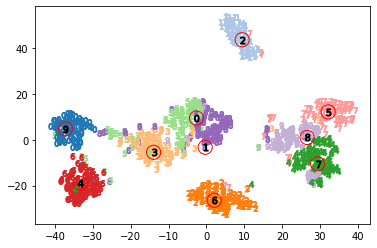

In [63]:
zs_g,ts_g,mus_g,logvars_g = take_latents()
points = TSNE(n_components=2,random_state=0).fit_transform(mus_g.view(-1,latent_dim).cpu().detach().numpy())
data_points = points[0:take_latent_max*batch_size]
center_points = points[take_latent_max*batch_size:]
data_labels = ts_g[0:take_latent_max*batch_size].cpu().detach().numpy()
center_labels = (-ts_g[take_latent_max*batch_size:]-1).cpu().detach().numpy()
drawpoints_with_centers(data_points,data_labels,center_points,center_labels)

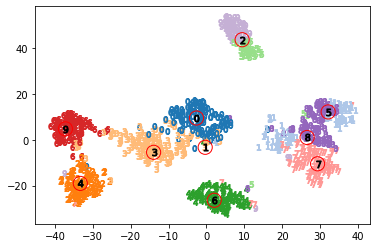

In [64]:
#kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,kmeans_model.labels_)
kmeans_model = KMeans(n_clusters=K_model_cluster, random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,kmeans_model.labels_[:take_latent_max*batch_size],center_points,center_labels)

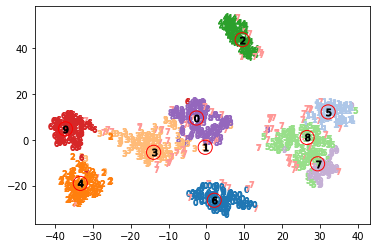

In [65]:
#gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
#drawpoints(points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy()))
gauss_model = GaussianMixture(n_components=K_model_cluster,covariance_type='diag',random_state=1).fit(mus_g.view(-1,latent_dim).cpu().detach().numpy())
drawpoints_with_centers(data_points,gauss_model.predict(mus_g.view(-1,latent_dim).cpu().detach().numpy())[:take_latent_max*batch_size],center_points,center_labels)

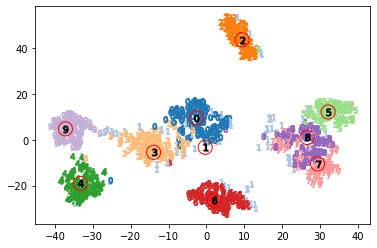

In [66]:

_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,logvar_c_g,inv_sm_pi_c_g,1)
#drawpoints(points[0:batch_size*take_latent_max,:],torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy())
#_,_,_,_,gamma_c_g,_ = gauss(mus_g[0:batch_size*take_latent_max,:,:],logvars_g,mu_c_g,chol_prec_seed_c_g,inv_sm_pi_c_g,1)
drawpoints_with_centers(data_points,torch.argmax(gamma_c_g,2).view(-1).cpu().detach().numpy(),center_points,center_labels)

In [67]:
show_generated_samples_c(mu_c_g,logvar_c_g)

In [68]:
optimizer.param_groups[0]['lr'],optimizer_clustering.param_groups[0]['lr'],beta

(0.0005083731656658001, 0.0005083731656658001, 1.0)

In [69]:
correspond_matrix = torch.zeros(K_real_cluster,K_model_cluster)

for i in range(batch_size*take_latent_max):

    for j in range(K_model_cluster):
        for k in range(K_real_cluster):
            if torch.argmax(gamma_c_g,2)[i,0] == j:
                if ts_g[i] == k:
                    correspond_matrix[k,j] +=1


In [70]:
correspond_matrix

tensor([[  0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,  94.],
        [  0.,   1.,  97.,   0.,   0.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   7.,   0.,   0.,   0.,   0.,  99.,   0.,   0.,   0.],
        [  0.,  12.,   0.,  90.,   0.,   1.,   1.,   0.,   0.,   0.],
        [  0.,   4.,   0.,   0.,   1.,   0.,   0.,  58.,  46.,   0.],
        [ 59.,  10.,   0.,  23.,   2.,   0.,   0.,   0.,   0.,   1.],
        [  0.,   1.,   0.,   0., 105.,   0.,   0.,   0.,   0.,   0.],
        [  0.,  18.,   0.,   0.,   0.,  80.,   1.,   2.,   2.,   0.],
        [ 67.,  15.,   0.,   7.,   0.,   0.,   0.,   2.,   2.,   2.],
        [  2.,   4.,   0.,   1.,   0.,   2.,   0.,  36.,  43.,   0.]])

In [71]:
correspond_matrix.sum()

tensor(1000.)

In [72]:
torch.max(correspond_matrix,0)

torch.return_types.max(
values=tensor([ 67.,  18.,  97.,  90., 105.,  80.,  99.,  58.,  46.,  94.]),
indices=tensor([8, 7, 1, 3, 6, 7, 2, 4, 4, 0]))

In [73]:
torch.max(correspond_matrix,0).values.sum()/(batch_size*take_latent_max)

tensor(0.7540)

In [74]:
F.softmax(inv_sm_pi_c_g,dim=2)

tensor([[[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000]]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [75]:
mu_c_g

tensor([[[ 2.2442e-01, -8.7611e-01, -1.5903e-03, -4.5152e-01, -4.7650e-01,
           5.7137e-01,  1.8624e-01,  2.5606e-01,  2.8197e-01,  2.9328e-01],
         [ 9.8201e-01,  3.5576e-01,  2.9081e-01, -6.4365e-01,  1.4926e+00,
           5.5201e-01, -6.7014e-01,  8.4418e-01,  8.7282e-01, -4.0843e-01],
         [-8.8960e-03, -4.8716e-03, -1.5705e-02, -3.0774e-04, -6.8223e-03,
          -2.0211e-02, -2.1080e-03, -1.3999e-02, -1.6052e-02,  1.7872e-03],
         [-8.1166e-01, -7.4946e-01,  1.1531e+00, -2.1945e+00, -1.4522e+00,
           2.3882e+00, -1.5172e+00,  6.1396e-01,  1.0907e+00, -3.8637e+00],
         [-3.3320e-01, -3.3290e-01, -3.5322e-01, -3.2845e-01, -3.1909e-01,
          -3.6463e-01, -3.2795e-01, -3.5360e-01, -3.5589e-01, -3.0966e-01],
         [ 7.8420e-01, -2.4421e-01,  2.7790e+00,  9.8956e-01,  8.8411e-01,
          -1.0530e+00, -8.0296e-02, -1.7535e+00, -6.7531e-01, -1.9008e-01],
         [-4.1934e-01, -1.2387e+00, -9.6728e-01, -7.3228e-01,  9.9128e-01,
          -1.0999e+

In [76]:
logvar_c_g.exp()

tensor([[[0.4885, 1.4535, 0.0392, 0.6029, 0.3409, 0.1540, 1.1430, 0.2626,
          0.2386, 0.6713],
         [0.3289, 1.3825, 0.0410, 0.8140, 0.6245, 0.3860, 0.4621, 0.5006,
          0.3532, 0.3726],
         [0.0177, 0.0179, 0.0185, 0.0178, 0.0182, 0.0180, 0.0178, 0.0181,
          0.0181, 0.0183],
         [0.4337, 2.9447, 0.1671, 0.6583, 0.4282, 0.2900, 0.3500, 0.2680,
          0.0976, 0.5875],
         [0.0255, 0.0261, 0.0260, 0.0257, 0.0260, 0.0268, 0.0257, 0.0268,
          0.0267, 0.0258],
         [0.4433, 1.6361, 0.1410, 0.5400, 2.0640, 1.2130, 0.5450, 0.6916,
          0.4337, 2.0381],
         [1.4917, 1.1972, 0.4042, 0.5142, 0.1659, 0.3911, 1.1533, 0.4081,
          0.2286, 0.2976],
         [1.8782, 2.3519, 2.8109, 1.4926, 0.9419, 1.7316, 1.6548, 1.0853,
          1.1261, 1.7496],
         [0.4473, 2.7156, 0.1452, 0.5886, 0.7383, 0.3474, 0.9567, 1.0891,
          1.1713, 0.3689],
         [0.0151, 0.0154, 0.0157, 0.0152, 0.0156, 0.0157, 0.0151, 0.0153,
          0.0154,

In [77]:
mus_g[0:10,:,0]

tensor([[ 4.3421e-01,  1.3562e+00,  3.5470e-03, -1.7407e+00, -3.1959e-01,
          3.5437e+00,  4.9397e-01,  1.3270e-03, -7.8515e-01,  1.0689e-02],
        [-6.5364e-01,  1.0807e+00, -1.1249e-02,  9.1600e-01, -3.5051e-01,
          1.9162e-01, -2.1119e+00,  2.4643e-01, -1.0314e+00,  1.5336e-02],
        [ 5.2754e-01, -1.0499e+00,  8.7016e-03, -3.9647e+00, -3.1830e-01,
          1.6898e-02,  1.5869e+00, -3.8510e-01, -5.4839e-01, -1.6396e-04],
        [-1.9769e-01,  1.1719e+00, -1.0426e-02,  1.0108e+00, -3.5809e-01,
         -1.1703e+00, -2.0068e+00,  7.0610e-01,  5.2595e-01,  8.5066e-03],
        [ 8.4764e-01,  1.1565e+00,  1.1926e-03, -1.3535e+00, -3.4757e-01,
          5.0731e-01, -1.1042e+00, -2.0383e+00,  8.9447e-02,  1.2967e-02],
        [-8.3499e-03, -1.7288e+00,  6.1467e-06, -1.0456e+00, -3.3147e-01,
          2.7162e-01, -3.0504e+00,  1.7474e+00, -1.6867e+00,  5.2630e-03],
        [-8.7616e-01, -9.7792e-02, -1.0836e-03, -2.9681e-01, -3.4222e-01,
         -3.6373e-01, -1.4476e+0

In [78]:
logvars_g.exp()[0:10,:,0]

tensor([[0.0389, 0.0181, 0.0186, 0.0109, 0.0264, 0.0148, 0.0093, 0.0119, 0.0209,
         0.0152],
        [0.0117, 0.0160, 0.0182, 0.0027, 0.0263, 0.0074, 0.0169, 0.0066, 0.0071,
         0.0150],
        [0.0278, 0.0214, 0.0184, 0.0156, 0.0249, 0.0065, 0.0083, 0.0070, 0.0109,
         0.0157],
        [0.0155, 0.0165, 0.0181, 0.0027, 0.0260, 0.0067, 0.0155, 0.0068, 0.0065,
         0.0151],
        [0.0151, 0.0135, 0.0179, 0.0062, 0.0250, 0.0062, 0.0086, 0.0073, 0.0069,
         0.0148],
        [0.0168, 0.0168, 0.0176, 0.0065, 0.0252, 0.0069, 0.0157, 0.0088, 0.0070,
         0.0149],
        [0.0154, 0.0124, 0.0179, 0.0049, 0.0257, 0.0063, 0.0149, 0.0071, 0.0079,
         0.0148],
        [0.0343, 0.0411, 0.0184, 0.0146, 0.0253, 0.0245, 0.0130, 0.0121, 0.0297,
         0.0149],
        [0.0198, 0.0114, 0.0185, 0.0036, 0.0261, 0.0084, 0.0252, 0.0132, 0.0114,
         0.0149],
        [0.0293, 0.0212, 0.0183, 0.0154, 0.0252, 0.0072, 0.0062, 0.0090, 0.0104,
         0.0155]], device='c

In [ ]:
'''
torch.save(
    {
        "model_state_dict" : model.state_dict(),
        "optimizer" : optimizer.state_dict(),
        "optimizer_clustering" : optimizer_clustering.state_dict(),
        "mu_c_g" : mu_c_g,
        "logvar_c_g" : logvar_c_g,
        "inv_sm_pi_c_g" : inv_sm_pi_c_g,
        "beta" : beta,
        "K_model_cluster": K_model_cluster
    },
    "./SGD-q-exponential/model/success949.tar"
)
'''
#sdata966 = torch.load("./SGD-q-exponential/model/success966.tar")
#mu_c_g = sdata966["mu_c_g"]